In [59]:
import pandas as pd
from sodapy import Socrata
import os
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
import datetime
from geopandas import GeoDataFrame as gdf
from shapely.geometry import Point
from shapely.geometry import Polygon
import json
%matplotlib inline

In [60]:
# Get Graffiti 311 Data from Chicago Data Portal API
graffiti_id = "cdmx-wzbz"
client = Socrata("data.cityofchicago.org", 'BOetEt3G4uynCIa1XQuFyRS8X')

g_results = client.get(graffiti_id, where="creation_date between '2017-01-01T00:00:00' and '2017-12-31T00:00:00'", limit = 2000000)
g_df = pd.DataFrame.from_records(g_results)

In [61]:
# Get Vacant and Abandoned Buildings 311 Data from Chicago Data Portal API
buildings_id = "yama-9had"
b_results = client.get(buildings_id, where="date_service_request_was_received between '2017-01-01T00:00:00' and '2017-12-31T00:00:00'", limit = 2000000)
b_df = pd.DataFrame.from_records(b_results)
b_df["street_address"] = b_df.address_street_number+" "+b_df.address_street_direction+" "+b_df.address_street_name+" "+b_df.address_street_suffix
b_df.rename(index=str, columns={"date_service_request_was_received": "creation_date", "service_request_type": "type_of_service_request"}, inplace = True)

In [62]:
# Get Alley Lights Out 311 Data from Chicago Data Portal API
alleys_id = "j9pw-ad5p"
a_results = client.get(alleys_id, where="creation_date between '2017-01-01T00:00:00' and '2017-12-31T00:00:00'", limit = 2000000)
a_df = pd.DataFrame.from_records(a_results)

In [63]:
# Get community areas data from Chicago Data Portal API
com_area_id = "igwz-8jzy"
ca_results = client.get(com_area_id)
ca_df = pd.DataFrame.from_records(ca_results)
ca_names = ca_df[["area_num_1", "community"]].copy()
ca_names.rename(index = str, columns = {"area_num_1": "community_area"}, inplace = True)

In [64]:
# Concatenate the 311 calls dataframes into one, merge in community area name, calculate response time variable
all_call = pd.concat([g_df, b_df, a_df], axis = 0, ignore_index = True)
all_call = pd.merge(all_call, ca_names, on = 'community_area', how = 'left')
all_call['response_time'] = (pd.to_datetime(all_call['completion_date']) - pd.to_datetime(all_call['creation_date'])).dt.days

In [65]:
# Clean where_is_the_graffiti_located_ column
mask = all_call.where_is_the_graffiti_located_ == "Express Way Job - DSS will NOT remove"
column_name = 'where_is_the_graffiti_located_'
all_call.loc[mask, column_name] = "Express Way Job"

In [66]:
# Count number of service requests by type
count_type = all_call.groupby("type_of_service_request").size().reset_index(name="count")
count_type['percent'] = count_type['count']/len(all_call)
count_type

,type_of_service_request,count,percent
0,Alley Light Out,27896,0.193265
1,Graffiti Removal,112779,0.781337
2,Vacant/Abandoned Building,3666,0.025398


We see in the table above that Graffiti Removal represents the largest share of 311 calls with 112,779 calls representing 78.13% of the calls in our sample, followed by Alley Light Out with 27,896 calls representing 19.33% of the calls and finally Vacant/Abandoned Building with just 3666 calls and 2.54% of the total sample.

Text(0.5,0,'Location of Reported Grafitti')

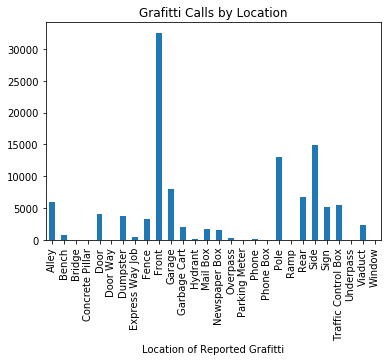

In [67]:
# Count number of Grafitti Removal calls by sub-type 
p1 = all_call.groupby(["where_is_the_graffiti_located_"]).size()
p1.plot.bar(title = "Grafitti Calls by Location")
plt.xlabel("Location of Reported Grafitti")

Text(0.5,0,'Are any people using vacant property?')

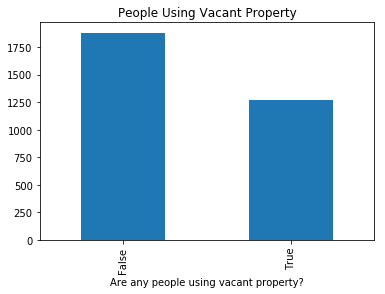

In [68]:
# Count number of Vacang/Abandoned Building calls by subtype
p1 = all_call.groupby(["any_people_using_property_homeless_childen_gangs_"]).size()
p1.plot.bar(title = "People Using Vacant Property")
plt.xlabel("Are any people using vacant property?")

Text(0.5,0,'Creation Month')

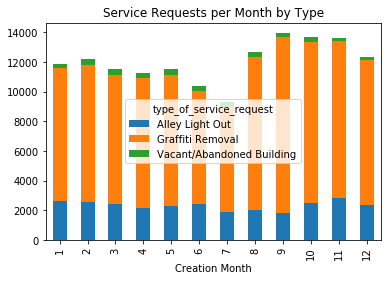

In [69]:
# Count number of service requests per month
pt = all_call.groupby([pd.to_datetime(all_call.creation_date).dt.month, all_call.type_of_service_request]).size().reset_index(name="count")
piv = pt.pivot(index='creation_date', columns='type_of_service_request', values='count')
piv.plot.bar(stacked= True, title = "Service Requests per Month by Type")
plt.xlabel("Creation Month")

In [70]:
# Count number of service requests by community area
grouped = all_call.groupby("community").size().reset_index(name="count")
grouped.sort_values(by = "count", ascending=False)

,community,count
75,WEST TOWN,10272
40,LOGAN SQUARE,8162
64,SOUTH LAWNDALE,6675
42,LOWER WEST SIDE,6216
11,BRIGHTON PARK,5784
7,AVONDALE,4751
37,LAKE VIEW,4730
43,MCKINLEY PARK,4693
26,GAGE PARK,3825
8,BELMONT CRAGIN,3744


In [71]:
#Calculate average response time by community area
grouped = all_call.groupby("community")['response_time'].mean().reset_index(name="average_response_time")
grouped.sort_values(by = "average_response_time", ascending=False)

,community,average_response_time
55,OAKLAND,43.829787
59,RIVERDALE,37.230769
45,MORGAN PARK,35.706320
73,WEST PULLMAN,32.679831
6,AVALON PARK,32.422330
9,BEVERLY,31.305000
29,GREATER GRAND CROSSING,30.977099
65,SOUTH SHORE,30.750000
14,CHATHAM,30.478149
76,WOODLAWN,29.675373


In [72]:
#Calculate average response time by type of service request (no data for vacant/abandoned buildings because no completion date provided)
grouped = all_call.groupby("type_of_service_request")['response_time'].mean().reset_index(name="average_response_time")
grouped.sort_values(by= "average_response_time", ascending=False)

,type_of_service_request,average_response_time
0,Alley Light Out,33.709252
1,Graffiti Removal,0.676226
2,Vacant/Abandoned Building,NaN


**Question 1 Response**

The findings above illuminate several interesting trends about responses to 311 requests in the city of Chicago. I highlight five interesting things I learned performing this analysis below:
1. The city of Chicago receives vastly more graffiti removal requests than alley lights out requests or vacant building requests, representing 78.3% of all the 311 calls in our sample. This result likely indicates the higher incidence of graffiti than vacant buildings or alley lights out. There are by contrast very few reports of Abandoned/Vacant Buildings, representing just 2.54% of the total calls in our sample. This may be due to the relative infrequency of Vacant/Abandoned Buildings or the lower proclivity of residents who live in the communities where Vacant/Abandoned Buildings occur to place a 311 request (see number 3 below).
2. There are significant disparities in the average response time to 311 calls in the city, with a slowest average response time (43.83 days in Oakland) that is more than 56 times greater than the fastest average response time (0.78 days in the Loop). The discrepancy may indicate that the city is prioritizing responding to 311 requests in certain areas, as areas that experience the fastest response times may be of key commercial importance (such as the Loop or O'Hare Airport) or higher-income areas while the areas with the slowest response times may be lower-income areas.
3. The community areas that place the most 311 requests (West Town at 10,272 calls and Logan Square at 8,162 calls) also experience some of the fastest response times (13th and 14th fastest respectively). By contrast, the community areas with the slowest reponse times (Oakland at 43.83 days and Riverdale at 37.23 days) report the fewest 311 requests of all community areas. This may reflect that citizens living in community areas with slow response times have become discouraged by the long wait times and have stopped reporting 311 requests, or it could indicate that the city allocates more resources to responding to calls in areas that report more 311 calls, so they can respond to those calls more quickly. 
4. The number of 311 requests placed per month is highest in the months of September, October, and November, largely driven by increases in the number of graffiti removal calls in those months. This was a surprising finding as I would have expected the number of graffiti removal requests to be highest in the summer when school is not in session.
5. Over 40% of buildings reported as vacant are being used by people (such as individuals experiencing homelessness or gangs) at the time of the report. Additionally, the most common location for graffiti that is reported for removal is the front of the location, followed by the side and then by a pole. 

In [73]:
# Query ACS Data from Census API
acs_results = requests.get('https://api.census.gov/data/2016/acs/acs5?get=NAME,B01003_001E,B02001_002E,B02001_003E,B15003_022E,B19001_001E&for=block%20group:*&in=state:17%20county:031&key=91aa6a44edb890abeea862f2d9befb5d520a5cc4')
data = acs_results.text
acs_df = pd.read_json(data)

In [74]:
# Clean ACS data frame and rename columns
variables = {'B01003_001E': "total_pop", 'B02001_002E': "total_white", 'B02001_003E': "total_black", 'B15003_022E': "bachelors_degree", 'B19001_001E': "total_income"}
acs_df.columns = acs_df.iloc[0]
acs_df.drop([0], inplace = True)
acs_df.rename(columns = variables, inplace=True)

In [75]:
# Calculate percentage statistics for count variables in ACS
acs_df['pct_black'] = pd.to_numeric(acs_df['total_black'])/ pd.to_numeric(acs_df['total_pop'])
acs_df['pct_white'] = pd.to_numeric(acs_df['total_white'])/ pd.to_numeric(acs_df['total_pop'])
acs_df['pct_bachelors'] = pd.to_numeric(acs_df['bachelors_degree'])/ pd.to_numeric(acs_df['total_pop'])
acs_df['GEOID']= acs_df["state"] + acs_df["county"] + acs_df["tract"] + acs_df["block group"]

In [76]:
# Read in census 2010 shapefile downloaded manually from census website
fp = "/Users/alenastern/Documents/Spring2018/Machine_Learning/tl_2017_17_bg/tl_2017_17_bg.shp"
census_shp = gpd.read_file(fp)

In [77]:
# Create Pandas GeoDataFrame from 311 data
geometry = [Point(xy) for xy in zip(pd.to_numeric(all_call.longitude), pd.to_numeric(all_call.latitude))]
all_call2 = all_call.drop(['latitude', 'longitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf_calls = gdf(all_call2, crs=crs, geometry=geometry)
gdf_calls = gdf_calls[gdf_calls['geometry'].is_valid]

In [78]:
# Merge census 2010 block group shapefile with ACS data
shp_geom = census_shp[["GEOID", "geometry"]].copy()
acs_df = pd.merge(acs_df, shp_geom, on = 'GEOID', how = 'left')

In [79]:
# Create Pandas GeoDataFrame from ACS data 
geometry = [Polygon(x) for x in acs_df.geometry]
acs_df2 = acs_df.drop(['geometry'], axis=1)
crs ={'init': 'epsg:4269'}
gdf_acs = gdf(acs_df2, crs=crs, geometry=geometry)
gdf_acs['total_income'] = pd.to_numeric(gdf_acs['total_income'])

In [80]:
#reproject American Community Survey data to same coordinate reference system of Chicago Open Data
gdf_acs = gdf_acs.to_crs({'init': 'epsg:4326'})
gdf_acs.crs

{'init': 'epsg:4326'}

In [81]:
#spatially join ACS data with Chicago 311 data by mapping 311 points to block group polygons
all_call_acs = gpd.sjoin(gdf_calls, gdf_acs, how="left")

In [82]:
#calculate average values of variables across all block groups in cook county
gdf_acs[['pct_black', 'pct_white', 'total_income', 'pct_bachelors']].mean()

pct_black          0.273980
pct_white          0.549943
total_income     488.756824
pct_bachelors      0.146207
dtype: float64

In [83]:
#Calculate average block group characteristics by type of service request
grouped = all_call_acs.groupby("type_of_service_request")[['pct_black', 'pct_white', 'total_income', 'pct_bachelors']].mean()
grouped

,pct_black,pct_white,total_income,pct_bachelors
type_of_service_request,,,,
Alley Light Out,0.403743,0.400884,452.323830,0.105551
Graffiti Removal,0.108343,0.614677,562.385718,0.170190
Vacant/Abandoned Building,0.804820,0.116517,373.668213,0.064021


In [84]:
#calculate average percentage of black individuals in block froups by type of service request over time
pt = all_call_acs.groupby([pd.to_datetime(all_call_acs.creation_date).dt.month, all_call_acs.type_of_service_request])['pct_black'].mean().reset_index(name='pct_black')
piv_pb = pt.pivot(index='creation_date', columns='type_of_service_request', values='pct_black')

In [85]:
#calculate average total income in block froups by type of service request over time
pt = all_call_acs.groupby([pd.to_datetime(all_call_acs.creation_date).dt.month, all_call_acs.type_of_service_request])['total_income'].mean().reset_index(name='total_income')
piv_ti = pt.pivot(index='creation_date', columns='type_of_service_request', values='total_income')

In [86]:
#calculate average percentage of white individuals in block froups by type of service request over time
pt = all_call_acs.groupby([pd.to_datetime(all_call_acs.creation_date).dt.month, all_call_acs.type_of_service_request])['pct_white'].mean().reset_index(name='pct_white')
piv_pw = pt.pivot(index='creation_date', columns='type_of_service_request', values='pct_white')

In [87]:
#calculate average percentage of individuals with bachelors degrees in block froups by type of service request over time
pt = all_call_acs.groupby([pd.to_datetime(all_call_acs.creation_date).dt.month, all_call_acs.type_of_service_request])['pct_bachelors'].mean().reset_index(name='pct_bachelors')
piv_pba = pt.pivot(index='creation_date', columns='type_of_service_request', values='pct_bachelors')

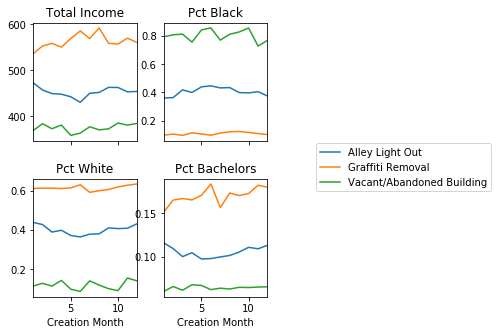

In [88]:
#plot average block characteristics by type of service request over time
fig, axes = plt.subplots(ncols=2, nrows = 2, sharex = True)

piv_ti.plot(ax=axes[0,0], legend = False, title = "Total Income")
piv_pb.plot(ax=axes[0,1], legend = False, title = "Pct Black")
piv_pw.plot(ax=axes[1,0], legend = False, title = "Pct White")
axes[1,0].set_xlabel("Creation Month")
piv_pba.plot(ax=axes[1,1], legend = False, title = "Pct Bachelors")
axes[1,1].set_xlabel("Creation Month")
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.55)   
fig.set_size_inches(7,5)
plt.show()

**Question 2 Response**

1. The types of blocks that get "Vacant/Abandoned Building" reported have high black populations with 80.5% black residents on average (significantly above the city-wide average of 27%) and have significantly below average income (363.67 versus the city-wide average of 488.76) and significantly below average proportion of residents with bachelors degrees (6.4% versus the city-wide average of 14.6%).
2. The types of blocks that get "Alley Light Out" reported are roughly even between the proportion of white and black population with approximately 40% white population and 40% black population, which represents a black population above the city-wide average and a white population below the city-wide average of 54%. The total income is slightly below average at 452.32 and proportion of residents with bachelor degrees is below average at 10.56%.
3. Over the course of 2017, while we see some fluctuation, we do not see significant overall changes in the characteristics of the blocks where "Alley Light Out", "Graffiti Removal" or "Vacant/Abandoned Building" is reported as shown in the chart above. The one exception is that the percentage of individuals with bachelors degrees in the blocks where "Grafitti Removal" is reported increases several percentage points from the beginning of the year to the end with a spike in May and steep subsequent drop in the summer. 
4. Blocks that get "Vacant/Abandoned Building" reported have on average higher percentage of black residents, lower percentage of white residents, lower income, and lower percentage of residents with bachelor degrees than the blocks that get "Alley Light Out" reported. In general the blocks where "Vacant/Abandoned Building" are on average more socioeconomically disadvantaged given lower total income and educational attainment (as measured by the percentage of individuals with Bachelors degrees) than those blocks where "Alley Light Out" is reported and have higher African American populations.



In [89]:
# obtain census geographies for 3600 W Roosevelt Ave by using census geocoder API 
result_geocode = requests.get('https://geocoding.geo.census.gov/geocoder/geographies/address?street=3600+W+Roosevelt+Ave&city=Chicago&state=IL&zip=&benchmark=8&vintage=8&format=json')
gc_text = result_geocode.text
gc_json = json.loads(gc_text)

In [90]:
# create geoid by concatenating FIPS code fields from census geocoder output
geoid = (str(gc_json['result']['addressMatches'][0]['geographies']['2010 Census Blocks'][0]['STATE']) +
str(gc_json['result']['addressMatches'][0]['geographies']['2010 Census Blocks'][0]['COUNTY']) +
str(gc_json['result']['addressMatches'][0]['geographies']['2010 Census Blocks'][0]['TRACT']) +
str(gc_json['result']['addressMatches'][0]['geographies']['2010 Census Blocks'][0]['BLKGRP'])) 
geoid

'170318430001'

In [91]:
# obtain subset of 311 data for the given geoid and calculate percentage of service requests by type
gc_df = all_call_acs[all_call_acs['GEOID'] == geoid]
grouped = gc_df.groupby('type_of_service_request').size()/len(gc_df)
grouped

type_of_service_request
Alley Light Out              0.577778
Graffiti Removal             0.333333
Vacant/Abandoned Building    0.088889
dtype: float64

In [92]:
# obtain subset of 311 data for Uptown and Garfield Park (East Garfield Park and West Garfield Park)
upt_gp_df = all_call_acs[(all_call_acs['community'] == 'UPTOWN') | (all_call_acs['community'] == 'EAST GARFIELD PARK') | (all_call_acs['community'] == 'WEST GARFIELD PARK')].copy()

In [93]:
# update East/West Garfield Park to Garfield Park and calculate number of calls by type
mask = (upt_gp_df.community == "EAST GARFIELD PARK") | (upt_gp_df.community == "WEST GARFIELD PARK")
column_name = 'community'
upt_gp_df.loc[mask, column_name] = "GARFIELD PARK"

grouped = upt_gp_df.groupby(['community','type_of_service_request']).size()
grouped

community      type_of_service_request  
GARFIELD PARK  Alley Light Out               617
               Graffiti Removal              454
               Vacant/Abandoned Building     149
UPTOWN         Alley Light Out               164
               Graffiti Removal             1853
               Vacant/Abandoned Building       1
dtype: int64

In [94]:
#calculate relative likelihood of a graffiti removal call coming from Garfield Park versus Uptown 
grouped[4]/grouped[1]

4.0814977973568283

In [95]:
#calculate relative likelihood of a graffiti removal call coming from Garfield Park versus Uptown for question 3C
160/100

1.6

**Question 3 Response**

1. I use the Census Geocoder tool to identify the block group associated with the given address. Note that the Census Geocoder did not identify an address associated with "3600 W Roosevelt Ave" and instead returned the geographies for "3600 W Roosevelt Rd." I confirmed through additional Google searches that a search for "3600 W Roosevelt Ave" redirects to "3600 W Roosevelt Road." Based upon the Census block group that 3600 W Roosevelt Road is located in and our existing 311 data for that Census block group in 2017, the call is most likely to be "Alley Light Out" (representing 57.8% of calls in that block group for 2017), followed by "Graffiti Removal" at 33.33% and "Vacant/Abandoned Building" at 8.9%.
2. It is more likely that the data came from Uptown than Garfield Park, as Uptown had 1853 "Graffiti Removal" calls and Garfield Park had 454 "Graffiti Removal" calls. As shown above, it is therefore more than four times as likely that the call came from Uptown than Garfield Park.
3. Per the data given, of the 260 total calls about "Graffiti Removal" in Garfield Park and Uptown, 100 come from Garfield Park and 160 come from Uptown. It is therefore 1.6 times more likely that a call about "Grafitti Removal" would come from Uptown than Garfield Park. 